In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

In [2]:
#Limiting data to that of the last 6 months.
from datetime import datetime
from dateutil.relativedelta import relativedelta
import calendar

now = datetime.today()
six_months = datetime.today() + relativedelta(months=-6, days = -3)

def convert(date):
    return str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)

def convert_2(date):
    return datetime.strptime(date, '%b %d, %Y').strftime('%Y-%m-%d')

def convert_3(date):
    return datetime.utcfromtimestamp(date).strftime('%Y-%m-%d')

def get_month(date):
    return datetime.strptime(date, '%Y-%m-%d').strftime('%B')

In [3]:
#Defining functions.
import requests
import io
import json

def coinmetrics(csv_name, start = six_months, end = now):
    
    time = (end - start).days

    url = 'https://coinmetrics.io/data/' + csv_name + '.csv'
    request = requests.get(url)
    
    coin = pd.read_csv(io.StringIO(request.text))[-time:]
    coin = coin[['date', 'txCount', 'marketcap(USD)', 'price(USD)', 'exchangeVolume(USD)']]
    coin.columns = ['Date', 'Transactions', 'Market Cap', 'Price', 'Exchange Volume']
    coin['Price Change'] = coin['Price'].pct_change()*100
    coin.reset_index(inplace = True, drop = True)
    
    return coin

def coinmarketcap(coin_name, start = six_months, end = now):
    
    start, end = convert(start), convert(end)
    
    coin = pd.read_html('https://coinmarketcap.com/currencies/' + coin_name + '/historical-data/?start=' + start
                        + '&end=' + end)[0]
    coin['Date'] = coin['Date'].apply(convert_2)
    coin = coin[['Date', 'Open*', 'Volume', 'Market Cap']]
    coin.columns = ['Date', 'Price', 'Exchange Volume', 'Market Cap']
    
    coin['Price'] = pd.to_numeric(coin['Price'], errors = 'coerce')
    coin['Exchange Volume'] = pd.to_numeric(coin['Exchange Volume'], errors = 'coerce')
    coin['Market Cap'] = pd.to_numeric(coin['Market Cap'], errors = 'coerce')

    coin = coin.iloc[::-1]
    coin['Price Change'] = coin['Price'].pct_change()*100
    
    return coin

def subreddit(subreddit_name, start = six_months, end = now):
    
    time = (end - start).days
    time_str = str(time + 1)
    
    sub = requests.get('https://api.pushshift.io/reddit/submission/search/?after=' + time_str +
                           'd&subreddit=' + subreddit_name + '&aggs=created_utc&frequency=d&size=0')
    sub_json = sub.json()
    submissions = pd.DataFrame(sub_json['aggs']['created_utc'])
    submissions.columns = ['Submissions', 'UTC']

    com = requests.get('https://api.pushshift.io/reddit/comment/search/?after=' + time_str +
                           'd&subreddit=' + subreddit_name + '&aggs=created_utc&frequency=d&size=0')
    com_json = com.json()
    comments = pd.DataFrame(com_json['aggs']['created_utc'])
    comments.columns = ['Comments', 'UTC']

    subreddit = submissions.merge(comments, on = 'UTC')
    subreddit['Date'] = subreddit['UTC'].apply(convert_3)

    return subreddit

def merged_coin(site_sub, subreddit_name, site_name = 'coinmetrics', start = six_months, end = now):

    if site_name == 'coinmetrics':
        coin = coinmetrics(site_sub, start, end)
    elif site_name == 'coinmarketcap':
        coin = coinmarketcap(site_sub, start, end)
    else:
        raise ValueError('Invalid Site')
        
    sub = subreddit(subreddit_name, start, end)
    coin = coin.merge(sub, on = 'Date')
    
    coin.drop('UTC', axis = 1, inplace = True)
    coin.dropna(inplace = True)
    coin.reset_index(inplace = True, drop = True)
    
    return coin

def correlation(site_sub, subreddit_name, site_name = 'coinmetrics', start = six_months, end = now,
                corr_type = 'pearson'):
    
    coin = merged_coin(site_sub, subreddit_name, site_name, start, end)
    coin['Month'] = coin['Date'].apply(get_month)
    
    sns.pairplot(coin, hue = 'Month', palette = 'viridis', diag_kind = 'hist')
    plt.show()
        
    return coin.corr(method = corr_type) #Change type of correlation here.

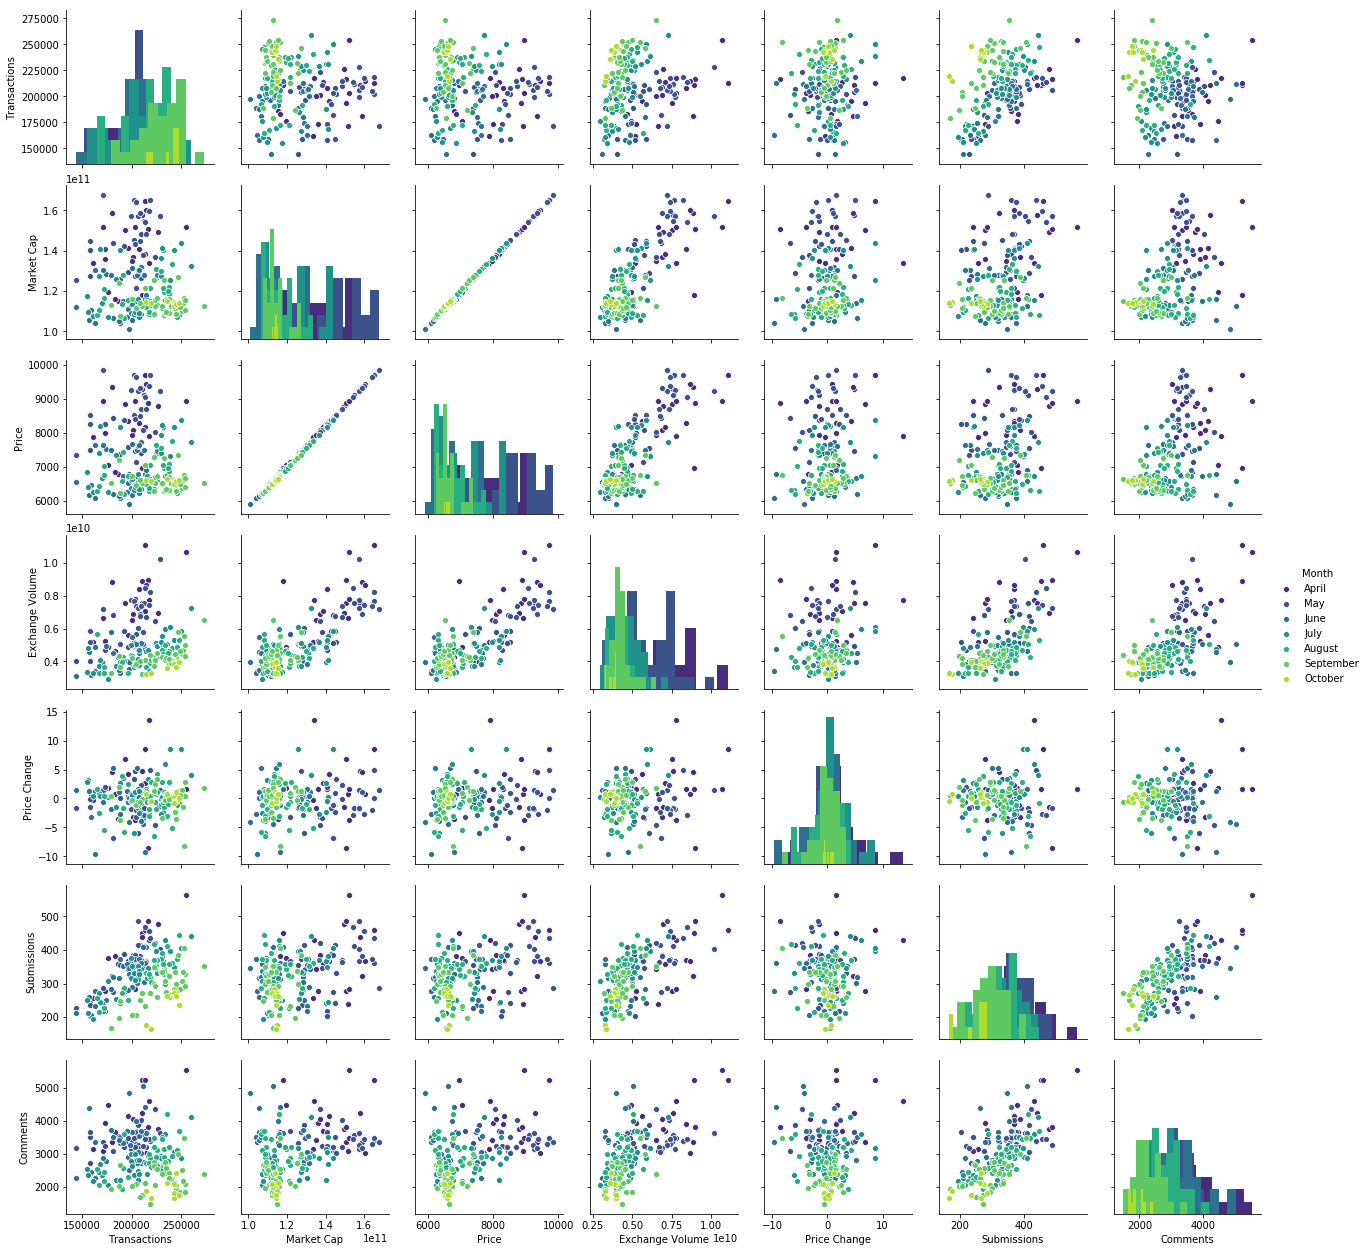

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,-0.072209,-0.089831,0.139983,0.045124,0.454560,-0.067620
Market Cap,-0.072209,1.000000,0.999467,0.779452,0.128201,0.358473,0.373608
Price,-0.089831,0.999467,1.000000,0.785328,0.126509,0.365453,0.392218
Exchange Volume,0.139983,0.779452,0.785328,1.000000,0.161121,0.607089,0.607388
Price Change,0.045124,0.128201,0.126509,0.161121,1.000000,0.003833,0.019967
Submissions,0.454560,0.358473,0.365453,0.607089,0.003833,1.000000,0.658675
Comments,-0.067620,0.373608,0.392218,0.607388,0.019967,0.658675,1.000000


In [4]:
#Bitcoin
correlation('btc', 'bitcoin')

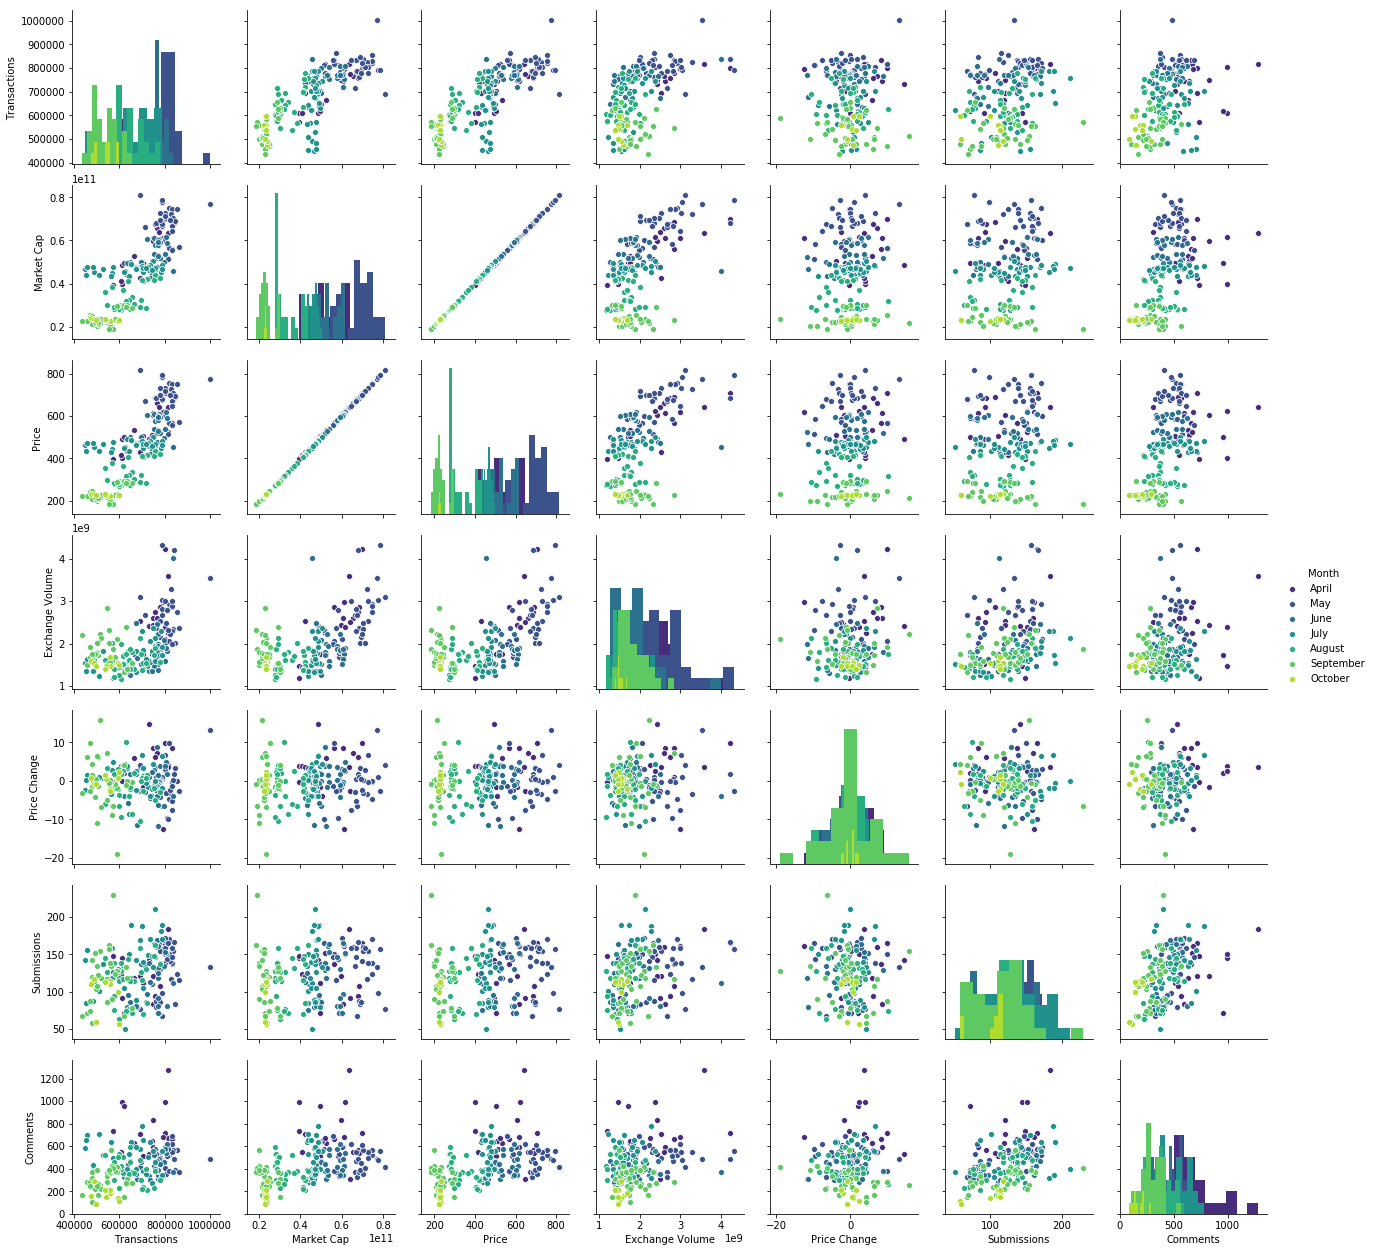

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.800051,0.799543,0.534826,0.028202,0.292183,0.345494
Market Cap,0.800051,1.000000,0.999900,0.578291,0.111745,0.177789,0.468524
Price,0.799543,0.999900,1.000000,0.581676,0.113310,0.177328,0.473314
Exchange Volume,0.534826,0.578291,0.581676,1.000000,0.095679,0.289022,0.299858
Price Change,0.028202,0.111745,0.113310,0.095679,1.000000,-0.062842,0.080538
Submissions,0.292183,0.177789,0.177328,0.289022,-0.062842,1.000000,0.401102
Comments,0.345494,0.468524,0.473314,0.299858,0.080538,0.401102,1.000000


In [5]:
#Ethereum
correlation('eth', 'ethereum')

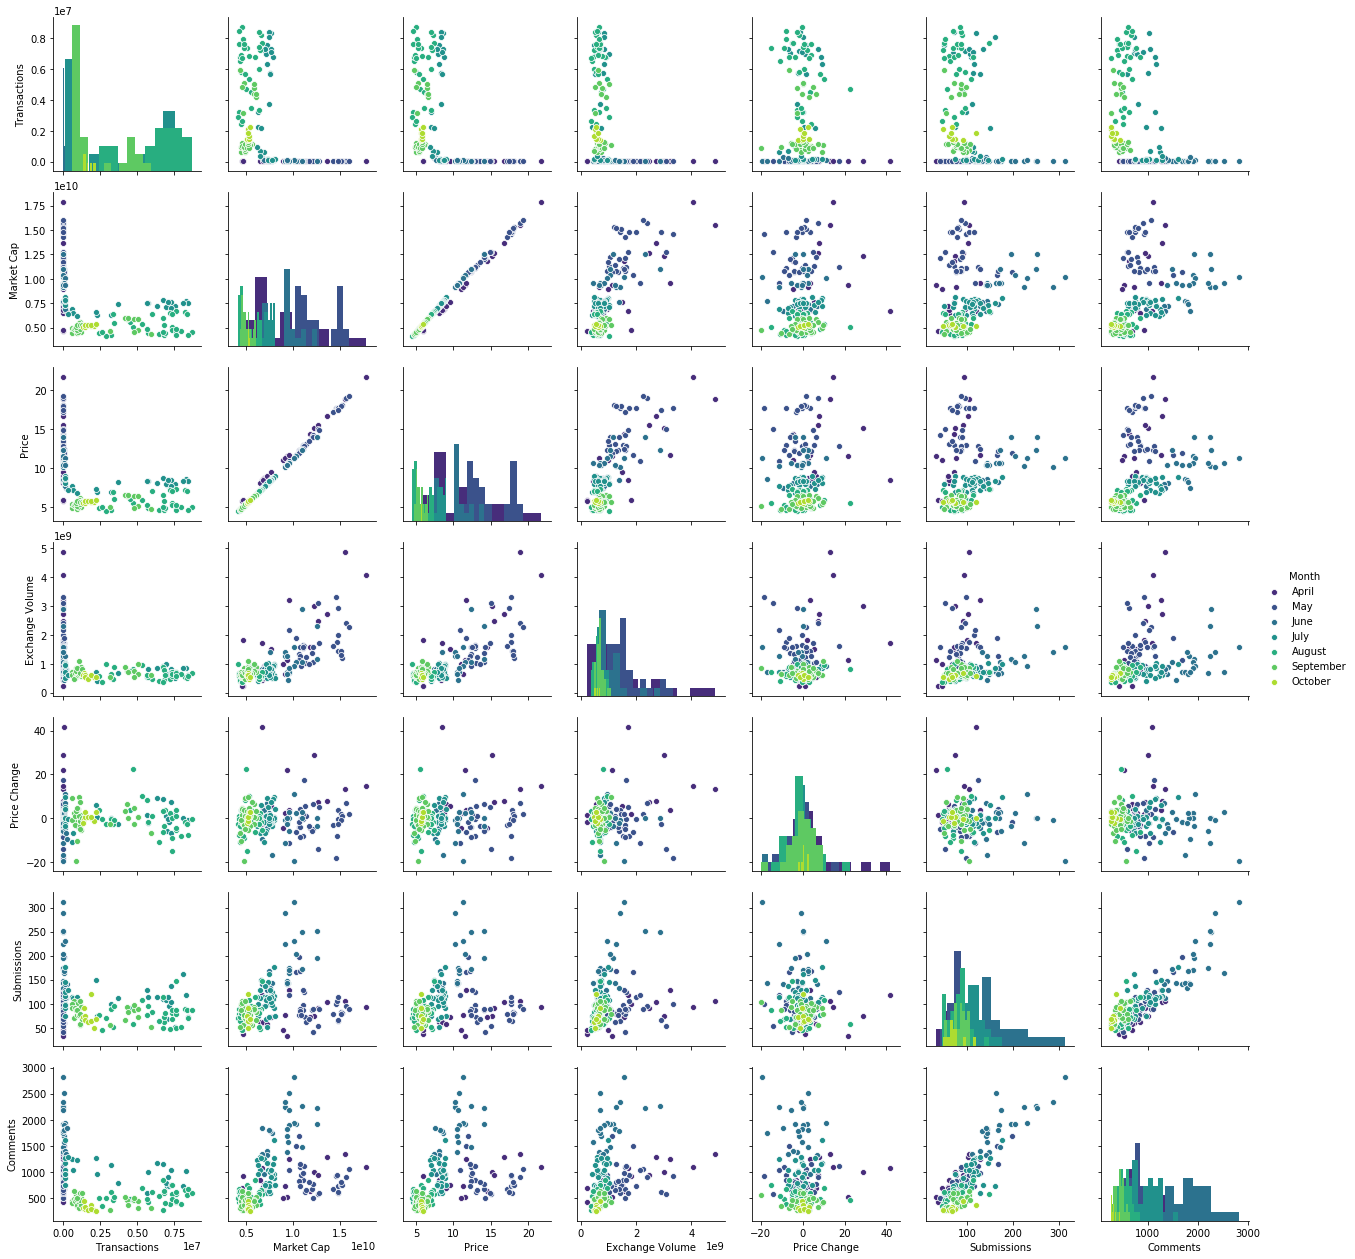

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,-0.473747,-0.485670,-0.373578,-0.065497,-0.221553,-0.359126
Market Cap,-0.473747,1.000000,0.996277,0.738443,0.063804,0.252308,0.416542
Price,-0.485670,0.996277,1.000000,0.754314,0.084793,0.206317,0.382449
Exchange Volume,-0.373578,0.738443,0.754314,1.000000,0.148654,0.199299,0.298513
Price Change,-0.065497,0.063804,0.084793,0.148654,1.000000,-0.096503,-0.074451
Submissions,-0.221553,0.252308,0.206317,0.199299,-0.096503,1.000000,0.854329
Comments,-0.359126,0.416542,0.382449,0.298513,-0.074451,0.854329,1.000000


In [6]:
#EOS
correlation('eos', 'eos')

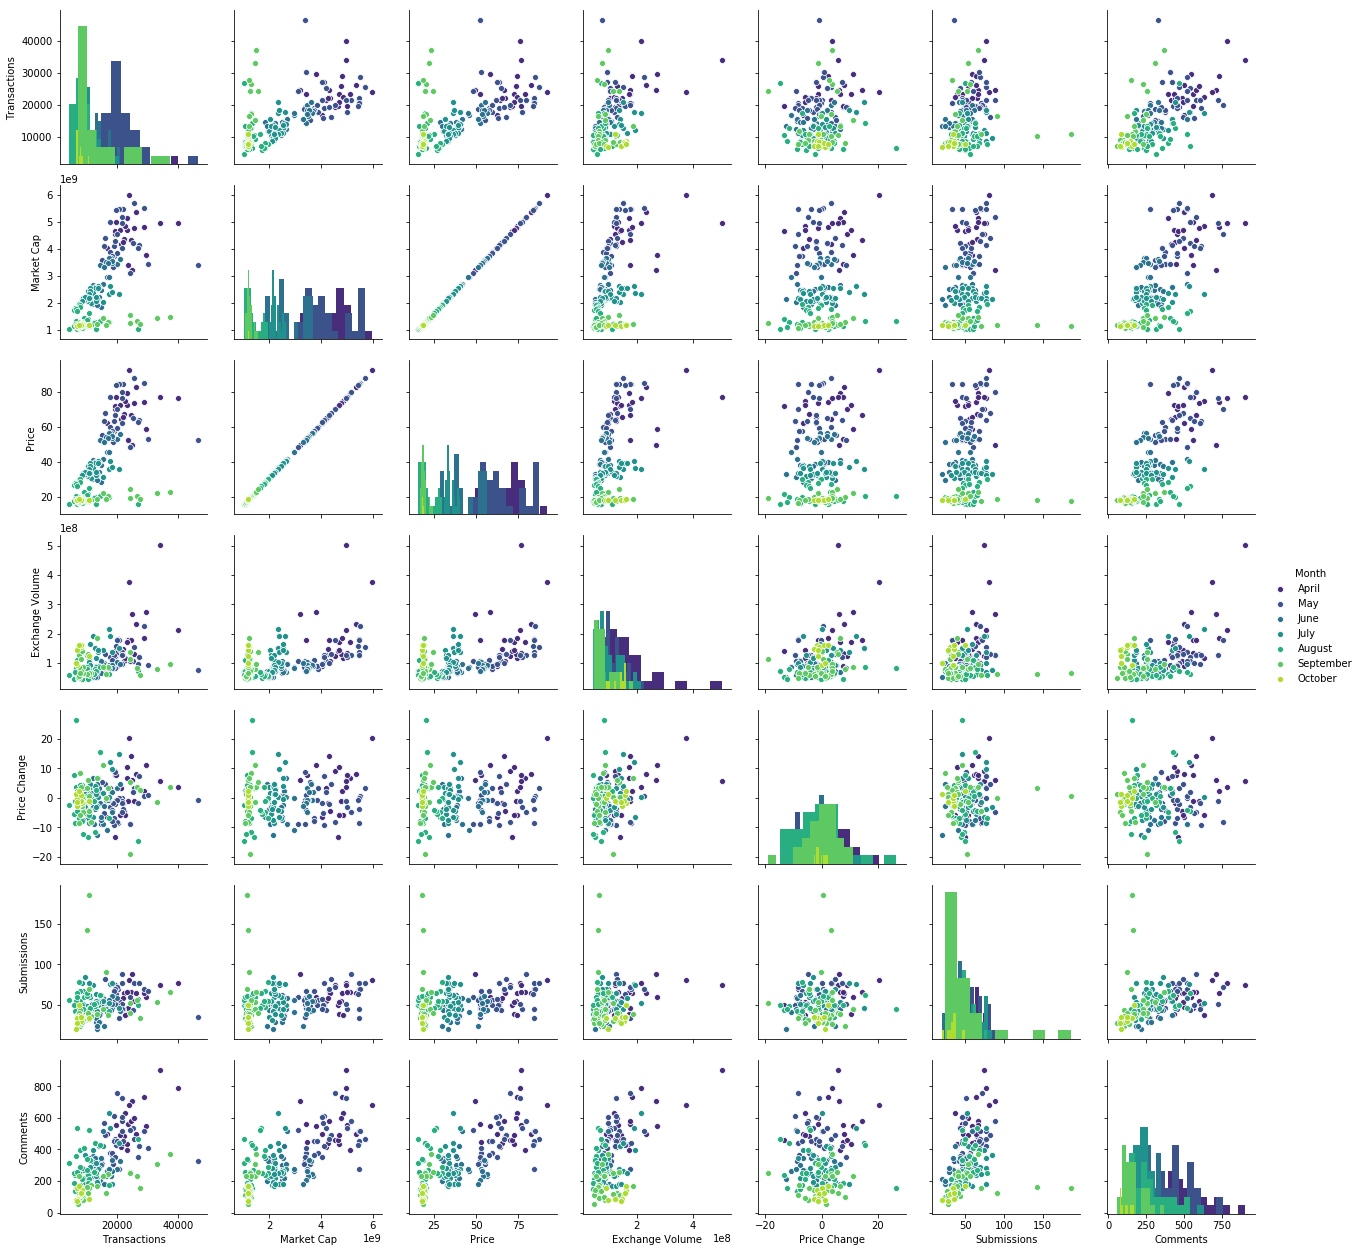

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.654878,0.654889,0.475286,0.128806,0.235599,0.642574
Market Cap,0.654878,1.000000,1.000000,0.521625,0.096232,0.264841,0.729330
Price,0.654889,1.000000,1.000000,0.521629,0.096248,0.264824,0.729326
Exchange Volume,0.475286,0.521625,0.521629,1.000000,0.306403,0.225123,0.544169
Price Change,0.128806,0.096232,0.096248,0.306403,1.000000,0.108987,0.063114
Submissions,0.235599,0.264841,0.264824,0.225123,0.108987,1.000000,0.375232
Comments,0.642574,0.729330,0.729326,0.544169,0.063114,0.375232,1.000000


In [7]:
#NEO
correlation('neo', 'neo')

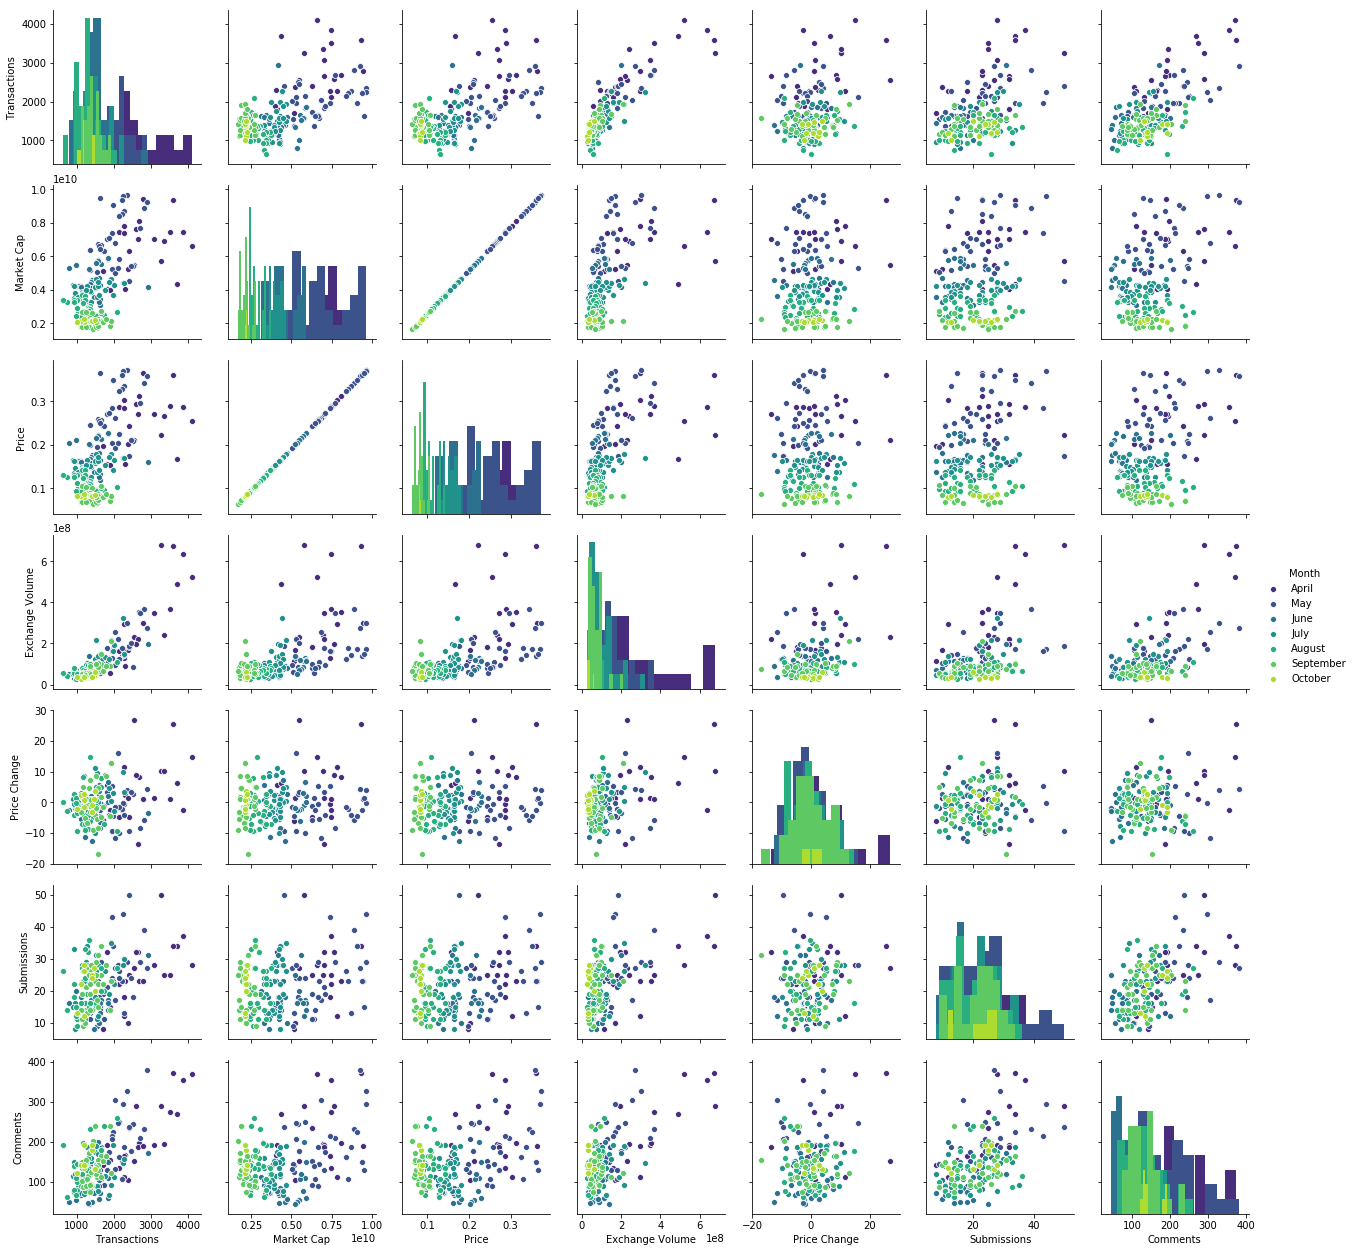

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.619271,0.619271,0.867053,0.270629,0.454341,0.680240
Market Cap,0.619271,1.000000,1.000000,0.584634,0.108484,0.229009,0.401695
Price,0.619271,1.000000,1.000000,0.584634,0.108484,0.229010,0.401695
Exchange Volume,0.867053,0.584634,0.584634,1.000000,0.343153,0.482087,0.644402
Price Change,0.270629,0.108484,0.108484,0.343153,1.000000,0.131421,0.148578
Submissions,0.454341,0.229009,0.229010,0.482087,0.131421,1.000000,0.522118
Comments,0.680240,0.401695,0.401695,0.644402,0.148578,0.522118,1.000000


In [8]:
#ADA
correlation('ada', 'cardano')

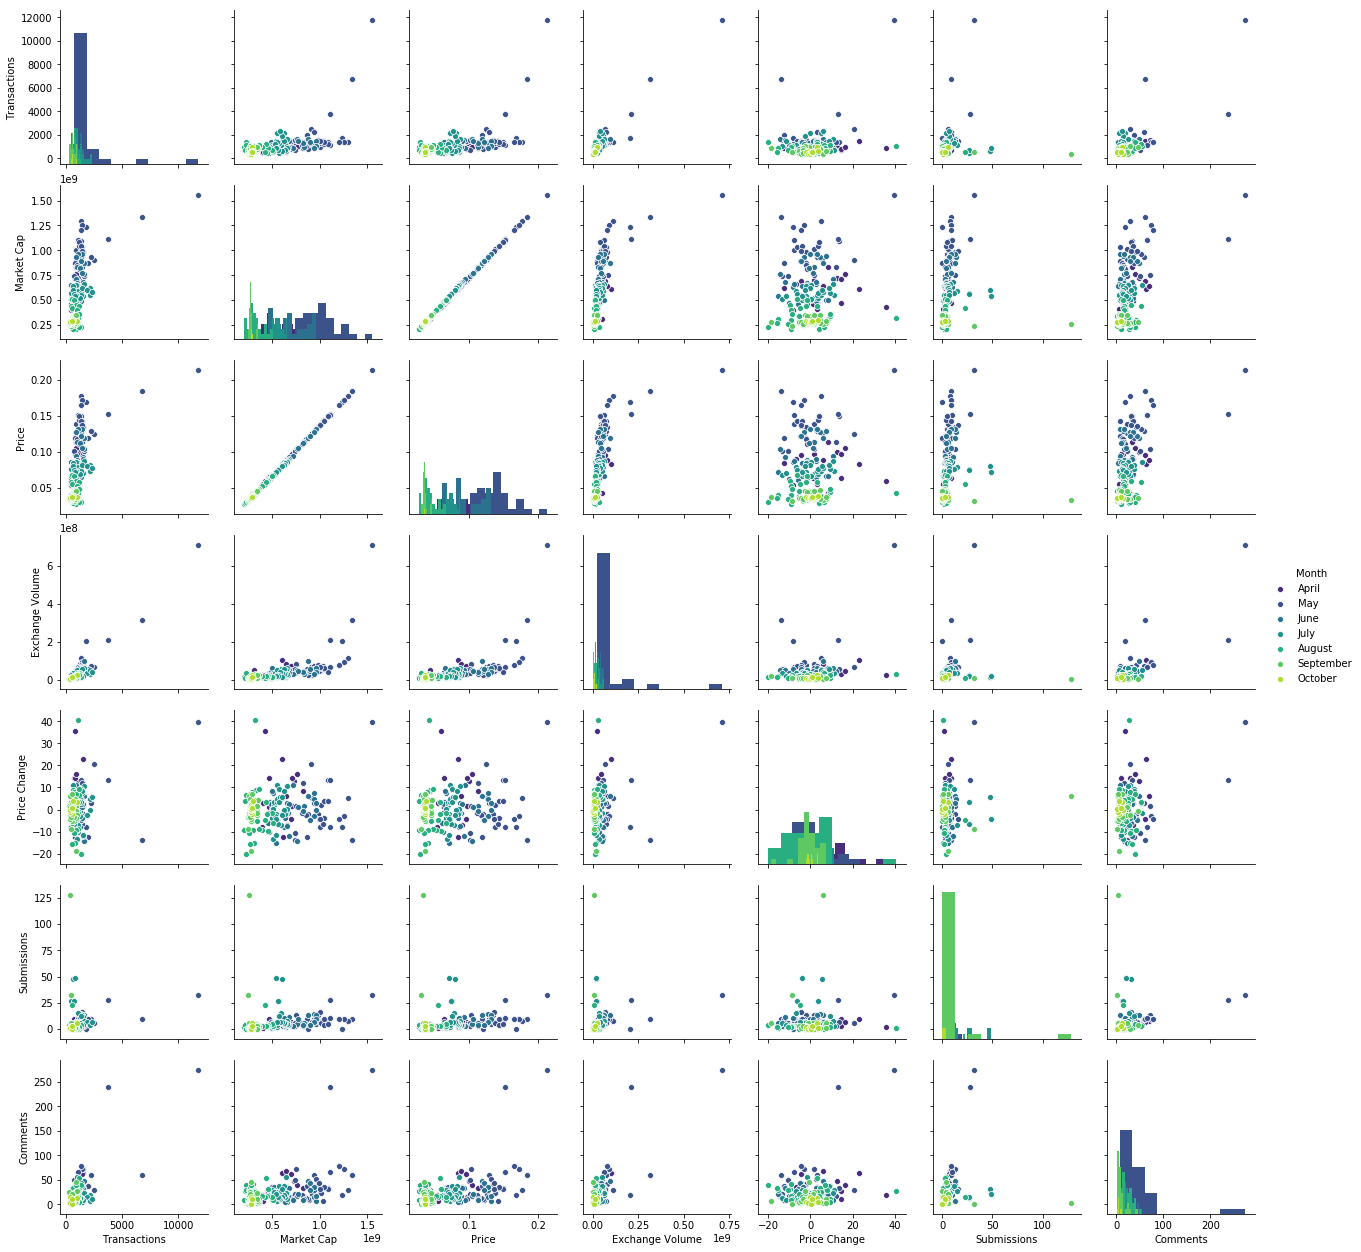

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.554770,0.553776,0.945308,0.266288,0.162705,0.736991
Market Cap,0.554770,1.000000,0.999603,0.611769,0.101240,0.140701,0.485953
Price,0.553776,0.999603,1.000000,0.612705,0.103235,0.138568,0.489590
Exchange Volume,0.945308,0.611769,0.612705,1.000000,0.295720,0.184996,0.780348
Price Change,0.266288,0.101240,0.103235,0.295720,1.000000,0.095661,0.301032
Submissions,0.162705,0.140701,0.138568,0.184996,0.095661,1.000000,0.206739
Comments,0.736991,0.485953,0.489590,0.780348,0.301032,0.206739,1.000000


In [9]:
#Zilliqa
correlation('zil', 'zilliqa')

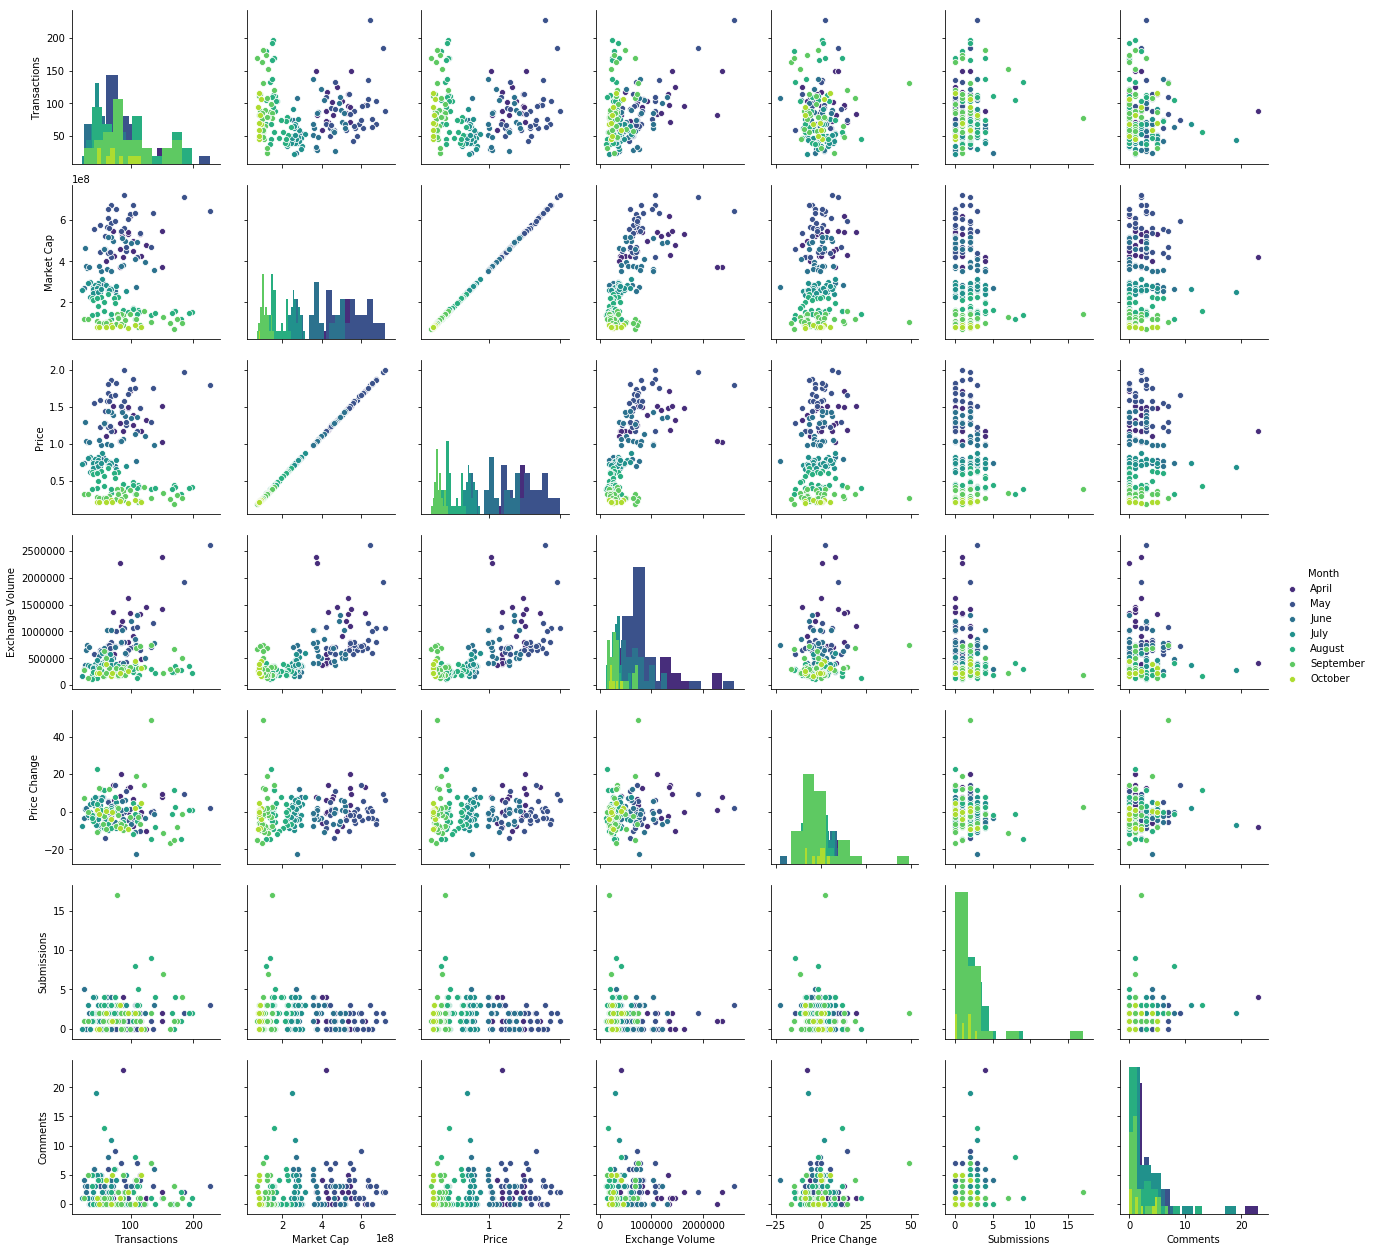

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.011922,0.009777,0.343081,-0.034988,0.094380,-0.046069
Market Cap,0.011922,1.000000,0.999929,0.641175,0.116352,-0.213974,0.067831
Price,0.009777,0.999929,1.000000,0.640044,0.115108,-0.212863,0.069855
Exchange Volume,0.343081,0.641175,0.640044,1.000000,0.163220,-0.155479,-0.001975
Price Change,-0.034988,0.116352,0.115108,0.163220,1.000000,-0.099930,0.034347
Submissions,0.094380,-0.213974,-0.212863,-0.155479,-0.099930,1.000000,0.155921
Comments,-0.046069,0.067831,0.069855,-0.001975,0.034347,0.155921,1.000000


In [10]:
#RChain
correlation('rhoc', 'RChain')

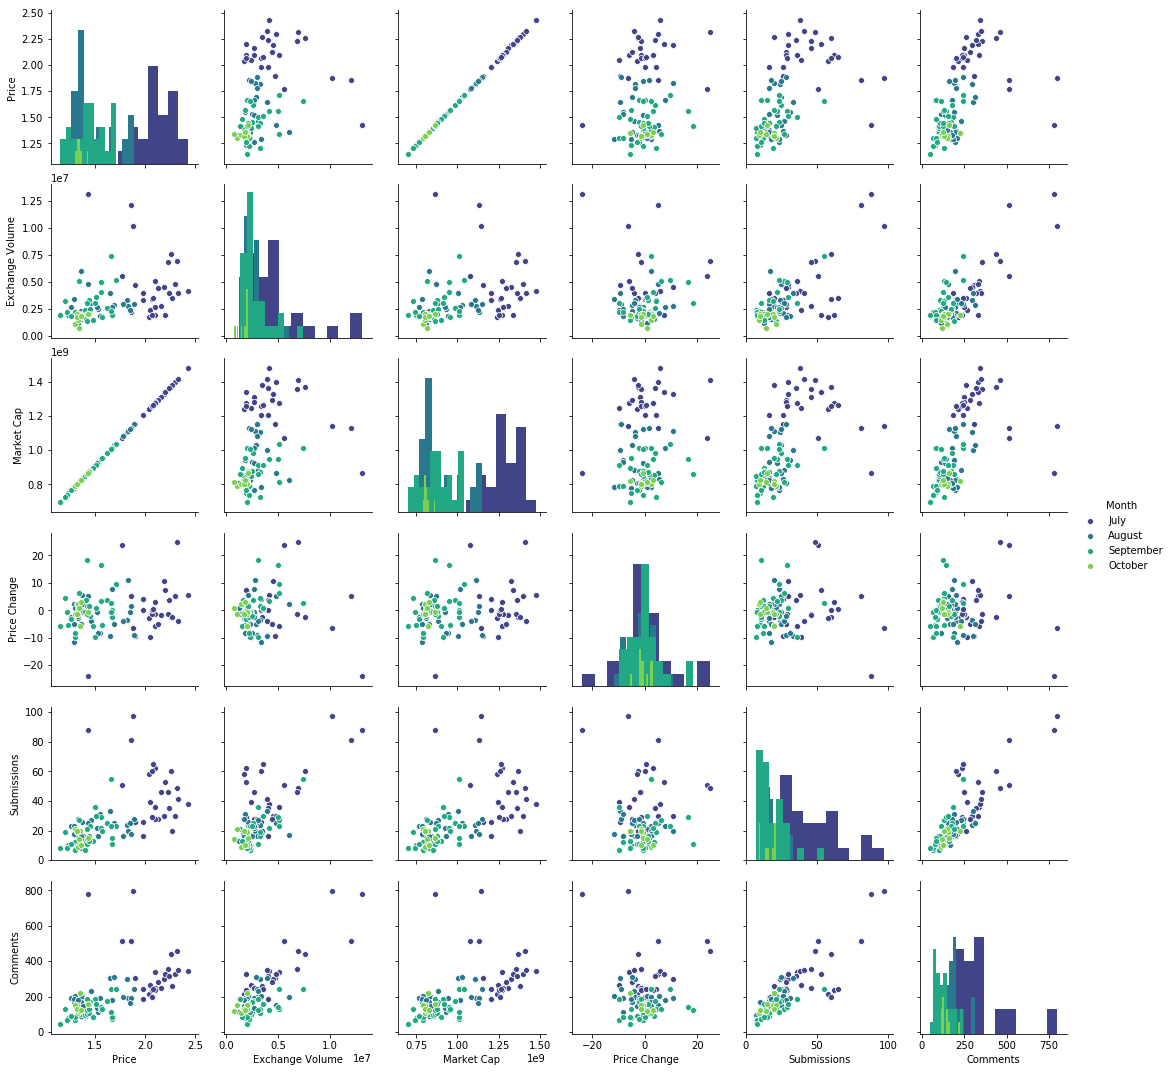

,Price,Exchange Volume,Market Cap,Price Change,Submissions,Comments
Price,1.000000,0.364355,0.999967,0.166178,0.565345,0.551427
Exchange Volume,0.364355,1.000000,0.363925,0.028340,0.730333,0.810161
Market Cap,0.999967,0.363925,1.000000,0.166310,0.564573,0.550717
Price Change,0.166178,0.028340,0.166310,1.000000,-0.013054,-0.032017
Submissions,0.565345,0.730333,0.564573,-0.013054,1.000000,0.839278
Comments,0.551427,0.810161,0.550717,-0.032017,0.839278,1.000000


In [11]:
#Tezos
correlation('tezos', 'tezos', 'coinmarketcap')